# CEU Review Analysis 
## Murat Tirkeshov

In [23]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

## Data

In [2]:
df = pd.read_csv('Giolitti (Ice Cream Shop in Rome) - Tripadvisor Reviews.csv')
df.head()

,Content,Date
0,Our favourite gelateria in Rome. An excellent ...,2023-01-03
1,Delicious and creamy what I can say more? If Y...,2023-01-07
2,Amazing choice of flavours! I had the coffee a...,2023-01-07
3,"What can I tell : it was a BIG ice cream, supe...",2023-01-06
4,Lots of Ice cream fruit flavors which are hard...,2023-01-07


### 	•	Task A (Sentiment Classification):
* Prompt A: A minimal directive – e.g., “Classify the sentiment of this review as Positive, Neutral, or Negative:” followed directly by the review text. This straightforward prompt relies on the model to complete the task with no additional guidance.
* Prompt B: A role-oriented prompt – e.g., “You are a sentiment classifier… Output one of the following: Positive, Neutral, or Negative. Content: [Review].” This prompt explicitly tells the model its role and the expected output format (one of the three labels). The aim is to focus the model on producing just the category name.
* Prompt C: A detailed instruction – e.g., “Sentiment Analysis Task: Please assess the sentiment… take everything into account (every feeling, sarcasm etc.). Choose from: Positive / Neutral / Negative. Content: ‘[Review]’.” This version gives the most explicit guidance, including mention of considering sarcasm/negation, hoping to improve handling of nuanced language. It sets the stage as a formal task to encourage a concise label output.

In [3]:
df = df.dropna(subset=["Content"])
df = df[df["Content"].str.len() > 30].reset_index(drop=True)
reviews = df["Content"].sample(200, random_state=42).tolist()

def create_prompt(review_text, version="A"):
    if version == "A":
        return f"Classify the sentiment of this review as Positive, Neutral, or Negative:\n\n{review_text}"
    elif version == "B":
        return f"You are a sentiment classifier for touristic places review classifications. Output one of the following: Positive, Neutral, or Negative.\nContent: {review_text}"
    elif version == "C":
        return f"Sentiment Analysis Task:\nPlease assess the sentiment of this customer review of a touristic destination. Read everything and take everything into account: every feeling, sarcasm etcetera. Choose from: Positive / Neutral / Negative.\n\nContent:\n\"{review_text}\""


for i in range(5):
    print(f"Content {i+1}:")
    print(create_prompt(reviews[i], version="A"))
    print("---\n")

Content 1:
Classify the sentiment of this review as Positive, Neutral, or Negative:

Cheap, tasty and big variety of flavors! Located in the city center. 

Could be a bit more as a portion though.
---

Content 2:
Classify the sentiment of this review as Positive, Neutral, or Negative:

What a fun experience! A friend referred us to go here, and it did not disappoint! Very easy process - pay first for the size (cone or cup, doesn’t matter), then look at flavors and order when it is your turn. Line went quickly. The...More
---

Content 3:
Classify the sentiment of this review as Positive, Neutral, or Negative:

Amazing selection of Gelatis.  Coffee, granitas and pastries were delicious as well.

Always lines but moves very swiftly.
---

Content 4:
Classify the sentiment of this review as Positive, Neutral, or Negative:

1) It’s in an exquisite location down an alley in the center of Rome 2) it’s relatively cheap at 3€ for a small 3) the portions are large, bigger than other shops I went 

In [4]:
test = df["Content"].sample(20, random_state=123)
test = pd.DataFrame(test)
test.reset_index(drop=True, inplace=True)
test

,Content
0,Wow. Oh My God. The Gelato. Seriously. What. T...
1,One of the famous gelato spots. The oldest in ...
2,I visited Giolotti’s twice when I was in Rome ...
3,Thankyou so much for looking after us all on M...
4,Definitely one of the best ice creams I’ve eve...
5,The gelato was so delicious that we come back ...
6,"I walked with my all family, for half of a day..."
7,We went twice during a recent trip. The fruit ...
8,Fantastic place serving great food and drink f...
9,Okay you guys this was the best ice cream Ive ...


#### Trues sentiment evaluated by human

In [5]:
test['true_sent'] = [
    "Positive", "Positive", "Positive", "Positive", "Positive",
    "Positive", "Negative", "Positive", "Positive", "Positive",
    "Positive", "Neutral", "Positive", "Positive", "Positive",
    "Positive", "Positive", "Positive", "Neutral", "Negative"
]
test

,Content,true_sent
0,Wow. Oh My God. The Gelato. Seriously. What. T...,Positive
1,One of the famous gelato spots. The oldest in ...,Positive
2,I visited Giolotti’s twice when I was in Rome ...,Positive
3,Thankyou so much for looking after us all on M...,Positive
4,Definitely one of the best ice creams I’ve eve...,Positive
5,The gelato was so delicious that we come back ...,Positive
6,"I walked with my all family, for half of a day...",Negative
7,We went twice during a recent trip. The fruit ...,Positive
8,Fantastic place serving great food and drink f...,Positive
9,Okay you guys this was the best ice cream Ive ...,Positive


#### GPT-4 output

In [6]:
test['GPT-4_sent_v1'] = [
    "Positive", "Negative", "Positive", "Neutral", "Positive",
    "Positive", "Negative", "Positive", "Positive", "Neutral",
    "Positive", "Positive", "Positive", "Positive", "Positive",
    "Positive", "Positive", "Positive", "Negative", "Negative"
]
test['GPT-4_sent_v2'] = [
    "Positive", "Negative", "Positive", "Positive", "Positive",
    "Positive", "Positive", "Positive", "Positive", "Neutral",
    "Positive", "Positive", "Positive", "Positive", "Positive",
    "Positive", "Positive", "Positive", "Negative", "Negative"
]
test['GPT-4_sent_v3'] = [
    "Positive", "Positive", "Positive", "Positive", "Positive",
    "Positive", "Negative", "Positive", "Positive", "Neutral",
    "Positive", "Positive", "Positive", "Positive", "Positive",
    "Positive", "Neutral", "Positive", "Negative", "Negative"
]

#### Flan-t5 output

In [7]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import pandas as pd


model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


versions = ["A", "B", "C"]

# Run predictions for all 3 versions
for version in versions:
    predictions = []
    for review in test["Content"]:
        prompt = create_prompt(review, version=version)
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True)
        outputs = model.generate(**inputs, max_new_tokens=10)
        sentiment = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
        predictions.append(sentiment)
    
    test[f"Sentiment_{version}"] = predictions

print(test[["Content", "Sentiment_A", "Sentiment_B", "Sentiment_C"]])

test.to_csv("sentiment_predictions_all_versions.csv", index=False)

                                              Content Sentiment_A Sentiment_B  \
0   Wow. Oh My God. The Gelato. Seriously. What. T...    Positive    Positive   
1   One of the famous gelato spots. The oldest in ...    Positive    Positive   
2   I visited Giolotti’s twice when I was in Rome ...    Positive    Positive   
3   Thankyou so much for looking after us all on M...    Positive    Positive   
4   Definitely one of the best ice creams I’ve eve...    Positive    Positive   
5   The gelato was so delicious that we come back ...    Positive    Positive   
6   I walked with my all family, for half of a day...    Negative    Negative   
7   We went twice during a recent trip. The fruit ...    Positive    Positive   
8   Fantastic place serving great food and drink f...    Positive    Positive   
9   Okay you guys this was the best ice cream Ive ...    Positive    Positive   
10  Best ice Cream in Rome hands down,\nGreat valu...    Positive    Positive   
11  This is reported to be t

### Task B (Key Complaint/Praise Extraction):
* Prompt A: A direct instruction – e.g., “Extract the most important sentence or phrase that expresses a key complaint or praise… Return no more than 4 words. Do not explain.” followed by “Review: [text]”. This prompt straightforwardly asks for the key phrase without any rationale or examples, and explicitly limits the answer length to encourage brevity.
* Prompt B: A role and rule-based prompt – e.g., “You are a customer sentiment analyst… extract the core complaint or praise, no more than 4 words… Extract only the most significant phrase… Do not write explanations. Review: [text]”. This provides some context (“customer sentiment analyst”) and reiterates the 4-word limit and requirement to pick the core issue or praise. The intention is to guide the model to focus and not deviate (similar to Prompt A but with slightly more clarity and authority).
* Prompt C: A structured prompt with examples – it explicitly states the task and provides bullet-point instructions on what to output depending on sentiment polarity, and it looks like:

In [8]:
def create_prompt_extraction(review_text, version="A"):
    if version == "A":
        return f"""Extract the most important sentence or phrase that expresses a key complaint or praise in the following customer review. Return no more than 4 words. Do not explain.:

Review:
"{review_text}"

Respond only with the extracted sentence or phrase."""
    elif version == "B":
        return f"""You are a customer sentiment analyst. Your task is to read the customer review and extract the core complaint or praise, no more than 4 words long.

Extract only the most significant phrase or sentence that shows what the customer felt most strongly about. Return only a phrase that is 4 words or fewer. Do not write explanations.
Review:
"{review_text}"
"""
    elif version == "C":
        return f"""Task: Identify the key complaint or praise in this review, no more than 4 words long.

Review:
"{review_text}"

Instructions:
- If the review is mostly positive, output the main thing being praised.  
- If mostly negative, output the main complaint.  
- No more than 4 words.

Output:"""

#### True extractions by human

In [9]:
test['true_extraction'] = [
    "great place", "amazing choice of flavourus", "good flavour", "exceptional gelato",
    "best ice creams", "delicious gelato", "disappointing service",
    "good flavours", "fantastic place", "best ice cream",
    "best ice cream", "huge selection", "never disappoints",
    "loads of choice", "delicious authentic gelato", "awesome ice cream",
    "amazing ba-ba", "best gelato", "rude service",
    "not the best flavours"
]

#### GPT-4 extractions

In [10]:
test['GPT-4_Extraction_v1'] = [
    "this is a great",
    "the queue wasn't bad.",
    "not as big. excellent",
    "no key phrase",
    "one of the best",
    "gelato was so delicious",
    "no key phrase",
    "flavors are the best",
    "fantastic place serving great",
    "this was the best",
    "best ice cream in",
    "no key phrase",
    "no key phrase",
    "you won’t be disappointed.",
    "absolutely delicious authentic gelato",
    "no key phrase",
    "the bá-bá is amazing",
    "best gelato in rome",
    "the gelato was great.",
    "sure not the best"
]
test['GPT-4_Extraction_v2'] = [
   "a great place",
    "amazing choice",
    "excellent range",
    "a perfect end",
    "the best ice",
    "so delicious that",
    "was disappointing up",
    "the best ones",
    "serving great food",
    "the best ice",
    "best ice",
    "no strong opinion",
    "no strong opinion",
    "amazing and",
    "absolutely delicious authentic",
    "no strong opinion",
    "is amazing just",
    "best gelato",
    "was great",
    "the best and"
]
test['GPT-4_Extraction_v3'] = [
    "Amazing gelato and toppings",
    "Intense fruit flavors",
    "Consistently great quality",
    "Exceptional service and gelato",
    "Super creamy ice cream",
    "Delicious gelato and service",
    "Disappointing ice cream quality",
    "Delicious fruit and pistachio",
    "Friendly staff and breakfast",
    "Best ice cream ever",
    "Amazing taste, great value",
    "Charge to sit inside",
    "Never disappoints, worth surcharge",
    "Amazing pistachio and hazelnut",
    "Authentic gelato, generous portions",
    "Awesome ice cream experience",
    "Amazing bá-bá dessert",
    "Best gelato, great flavors",
    "Rude service, disorganized line",
    "Overrated, poor flavors"  
]

### Task C (Summarization):
* Prompt A: A simple instruction – “Summarize this customer review in 1-2 sentences:” followed by the review text. This is a basic zero-shot summary request, leaving it entirely to the model how to condense the content.
* Prompt B: A role prompt with constraints – e.g., “You are a summarization assistant… return a concise summary. It should be 1–2 sentences and capture the main idea and sentiment… factual and in third-person.” followed by the review. This guides the model on style (third-person, no added opinions) and content (main idea and sentiment). The goal is to reduce rambling or inclusion of irrelevant details by clearly stating the requirements.
* Prompt C: A few-shot prompt – we prepend two example reviews and their correct 1-2 sentence summaries, then ask “Now, summarize the following review…”. The examples illustrate how a positive review’s summary should look (enthusiastic, highlighting what was loved) and how a negative review’s summary should look (highlighting dissatisfaction). By seeing these examples, LLaMA 3 is expected to mimic the desired summarization style and content selection for the new review. This is the most complex prompt, aimed at maximizing performance through demonstration.

In [11]:
def create_prompt_summary(review_text, version="A"):
    if version == "A":
        return f"""Summarize this customer review in 1 - 2 sentences:\n\n{review_text}"""
    
    elif version == "B":
        return f"""You are a summarization assistant. Your task is to read the following review and return a concise summary.\nIt should be 1–2 sentences and capture the main idea and sentiment.The summary should be factual and in third-person (do not add opinions not in the review).\n\nReview:\n{review_text}"""

    elif version == "C":
        return f"""Here are example reviews and summaries:

Review: "The ice cream was amazing and the staff were so friendly. A must-visit!"
Summary: The reviewer loved the gelato and the friendly staff, calling Giolitti a must-visit.

Review: "We waited forever and the ice cream was average. Not worth it."
Summary: The reviewer felt the gelato was average and not worth the long wait.

Now, summarize the following review in 1-2 sentences.\n\nReview:\n\"{review_text}\"\n\nSummary:"""

#### GPT-4 output

In [12]:
test['GPT-4_summary_v1'] = [
    "This customer is extremely enthusiastic about the gelato, praising the overall experience and describing the unique ordering process where you choose your toppings first, pay, and then receive your dessert. They clearly loved the place and highly recommend it.",
    "This review highlights a famous and historic gelato spot in Rome, praised for its intense fruit flavors and wide variety. The customer enjoyed a pleasant evening visit with minimal queues, conveniently located near the Pantheon.",
    "The reviewer returned to Giolitti’s after a few years and was pleased to find the quality and flavor of the gelato just as excellent as before, prompting multiple visits during their recent trip to Rome.",
    "The reviewer expresses heartfelt thanks for the exceptional service and gelato during a group visit from England, describing it as the perfect end to a perfect night. They especially loved the hazelnut and sour cherry flavors.",
    "The reviewer describes the ice cream as one of the best they’ve ever had, highlighting its creamy texture, generous portions, and overall deliciousness. They strongly recommend it to anyone visiting Rome.",
    "The reviewer loved the gelato so much they returned daily to try new flavors, giving special thanks to a helpful staff member, Mariano, for his excellent flavor suggestions. They also praised the chocolate varieties and highlighted the friendly, attentive service in both English and Chinese.",
    "The reviewer had a disappointing experience after a long walk with their family to a guidebook-recommended gelato shop, criticizing the flavor and texture of the ice cream and noting that they didn’t finish it. They also described the staff as arrogant, contributing to their negative impression.",
    "The reviewer visited twice during their trip and especially enjoyed the fruit flavors, with strawberry and black licorice standing out for authenticity, and pistachio also praised. They advise future visitors to pay first before ordering gelato.",
    "The reviewer praises this place for its excellent breakfast offerings, friendly and accommodating staff, and consistently good coffee and croissants. They appreciated the staff’s willingness to assist in English when needed.",
    "The reviewer enthusiastically declares this the best ice cream they’ve ever had, urging others to try the Nutella flavor, which they describe as otherworldly.",
    "The reviewer calls this the best ice cream in Rome, praising its amazing flavors and great value for money. They highly recommend trying the Nutella flavor.",
    "The reviewer notes this as Rome’s oldest gelato shop, known for its wide selection of gelato, pastries, and candy. While it’s very popular and often crowded, they mention the downside of an extra charge for indoor seating.",
    "The reviewer shares a positive return visit with friends after Sunday lunch, enjoying gelato with cream and coffee. They find the extra charge for sitting inside justified by the quality and experience.",
    "The reviewer praises the shop’s attractive setting and wide dessert selection, calling it fabulous. They were especially impressed by the pistachio and hazelnut flavors—even though they’re not usually an ice cream fan.",
    "The reviewer raves about the authentic and delicious gelato, highlighting the wide variety of flavors, generous portions, and friendly service. They strongly recommend visiting.",
    "The reviewer dismisses claims of the place being a tourist trap, instead describing it as fun and enjoyable with excellent ice cream. They consider it a must-visit spot in Rome.",
    "The reviewer highly recommends the bá-bá dessert, describing it as perfectly made, though they haven’t tried the ice cream. They suggest the dolce alone makes the visit worthwhile.",
    "The reviewer confidently claims this is the best gelato in Rome, praising its old-school atmosphere and standout flavors like cinnamon and salted caramel. They believe it’s well worth the visit and the wait in line.",
    "The reviewer enjoyed the gelato after a visit to the Pantheon, following a hotel recommendation. However, they were disappointed by the rude service and the disorganized queuing system, which affected their overall experience.",
    "The reviewer strongly criticizes the gelato as overrated and tailored for tourists, stating they’ve had much better in Rome. They describe it as one of the worst tourist experiences and advise against buying into the hype.",
]
test['GPT-4_summary_v2'] = [
    "The reviewer expresses strong enthusiasm for the gelato, describing the experience as excellent and highlighting the process of selecting toppings and paying before receiving the order.",
    "The reviewer describes this gelato spot as a well-known and historic location near the Pantheon, praising the intense fruit flavors and pleasant experience with minimal queue in the evening.",
    "The reviewer visited Giolitti’s twice during their recent trip to Rome and noted that the quality and flavor remained consistently excellent, as in previous visits.",
    "The reviewer, part of a large group from England, praises the exceptional service and gelato on Monday night, describing it as the perfect end to their evening.",
    "The reviewer describes the ice cream as one of the best they’ve ever had, highlighting its creamy texture, generous portions, and recommending it to Rome visitors.",
    "The reviewer returned daily for the delicious gelato, especially enjoying the chocolate flavors, and praised staff member Mariano for his thoughtful and helpful flavor recommendations.",
    "The reviewer was disappointed by the flavors and texture of the ice cream, noting they did not finish them, and also criticized the staff for being arrogant.",
    "The reviewer visited twice during their trip, praising the fruit flavors—especially strawberry—and the authenticity of the black licorice, also recommending pistachio and noting the need to pay before ordering.",
    "The reviewer praises the breakfast offerings, friendly staff who assisted in English, and consistently good coffee and croissants, highlighting a positive overall experience.",
    "The reviewer enthusiastically claims this was the best ice cream they’ve ever had, highly recommending the Nutella flavor as exceptional.",
    "The reviewer describes it as the best ice cream in Rome, praising the excellent value and amazing flavors, with a strong recommendation for the Nutella flavor.",
    "The reviewer notes that this is reportedly the oldest gelato shop in Rome, offering a wide selection of gelato, pastries, and candy, with long lines due to its popularity and an added charge for indoor seating.",
    "The reviewer and friends visited after Sunday lunch, enjoyed gelato with cream and coffee, and felt that the additional charge for seating was well worth it given the consistent quality.",
    "The reviewer praises the wide selection of ice cream and desserts, describing the pistachio and hazelnut flavors as amazing—even as someone who usually doesn’t enjoy ice cream.",
    "The reviewer highlights the authentic and delicious gelato, abundant flavor options, generous portions, and friendly service, strongly recommending the place.",
    "The reviewer refutes claims that the place is a tourist trap, describing it as enjoyable with excellent ice cream and recommending it as a must-visit in Rome.",
    "The reviewer praises the bá-bá dessert as excellent and recommends trying the sweets, though they did not sample the ice cream.",
    "The reviewer describes it as the best gelato in Rome, appreciating the old-school atmosphere, wide variety of flavors—especially cinnamon and salted caramel—and considers it worth the wait.",
    "The reviewer enjoyed the gelato after a visit to the Pantheon but was disappointed by the rude service and the disorganized queue system.",
    "The reviewer strongly criticizes the gelato as overrated and tourist-focused, stating they’ve had much better elsewhere in Rome and consider it one of the worst tourist spots.",
]
test['GPT-4_summary_v3'] = [
    "The reviewer was blown away by the gelato and enthusiastic about the experience, praising both the quality and the fun, structured ordering process. They found the toppings irresistible and considered the place exceptional.",
    "The reviewer enjoyed their visit to this historic gelato spot near the Pantheon, praising the wide variety of flavors and the intensity of the fruit options. They found the evening visit pleasant with minimal queues.",
    "The reviewer visited Giolitti’s twice on their recent trip and noted that the quality and flavor remained consistently excellent, just as they remembered from previous visits.",
    "The reviewer, part of a large group from England, praised the exceptional service and gelato at Giolitti, calling it a perfect end to their evening. They especially enjoyed the hazelnut and sour cherry flavors.",
    "The reviewer raved about the creamy, delicious ice cream and generous portions, calling it one of the best they’ve ever had. They highly recommend visiting when in Rome.",
    "The reviewer loved the gelato so much they returned daily to try new flavors, especially praising the chocolate varieties. They gave a special thanks to Mariano for his friendly and thoughtful flavor recommendations.",
    "The reviewer was deeply disappointed by the flavors and texture of the ice cream, stating it wasn’t worth the long walk and even left it unfinished. They also criticized the staff for being arrogant.",
    "The reviewer visited twice and especially loved the fruit flavors—highlighting strawberry—as well as the authentic black licorice and pistachio. They also advised future visitors to pay first before ordering.",
    "The reviewer praised the fantastic breakfast offerings, including hot coffee and tasty croissants, and appreciated the friendly staff who kindly assisted in English when needed.",
    "The reviewer called this the best ice cream they’ve ever had and passionately recommended the Nutella flavor, describing it as out of this world.",
    "The reviewer declared it the best ice cream in Rome, praising the excellent value and amazing flavors, with a special recommendation for the Nutella.",
    "The reviewer noted that this historic gelato shop offers a wide variety of gelato, pastries, and candy, and is very popular with long lines. They mentioned a downside: there’s a fee to sit at a table inside.",
    "The reviewer returned with friends after Sunday lunch and enjoyed gelato with cream and coffee, praising the consistent quality. They felt the extra charge for sitting down was well worth it.",
    "The reviewer found the place beautiful with plenty of dessert options and was impressed by the pistachio and hazelnut flavors, despite not usually being an ice cream fan. They highly recommend it.",
    "The reviewer loved the authentic gelato, generous portions, and wide variety of flavors, and praised the friendly staff. They highly recommend the experience.",
    "The reviewer dismissed claims of it being a tourist trap, describing the place as fun and breezy with amazing ice cream. They strongly recommend it as a must-visit in Rome.",
    "The reviewer praised the bá-bá dessert as excellent and authentic, noting they didn’t try the ice cream but still found the sweets worth trying.",
    "The reviewer declared it the best gelato in Rome, highlighting its old-school charm and delicious flavors like cinnamon and salted caramel. They felt it was well worth the wait.",
    "The reviewer enjoyed the gelato and appreciated the recommendation from their hotel but were disappointed by the rude service and the chaotic, disorganized line.",
    "The reviewer strongly criticized the gelato, calling it overrated and tailored for tourists, and claimed to have had much better elsewhere in Rome. They considered it one of the worst tourist experiences.",
]

### Confusion matrixes for Task A


📊 GPT-4A - Sentiment Classification
Accuracy: 0.75
F1 Score: 0.51


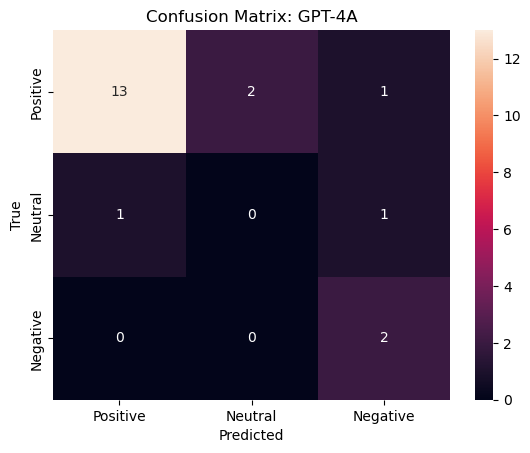


📊 GPT-4B - Sentiment Classification
Accuracy: 0.75
F1 Score: 0.42


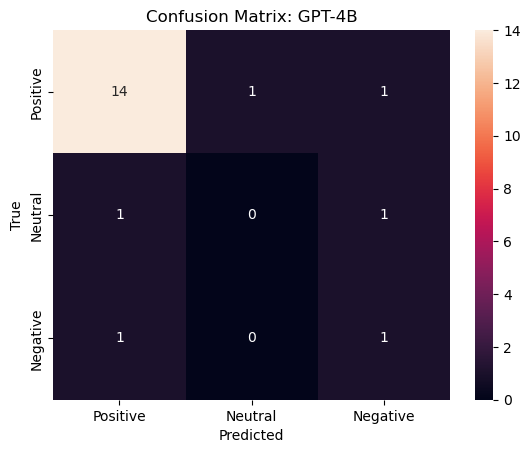


📊 GPT-4C - Sentiment Classification
Accuracy: 0.80
F1 Score: 0.57


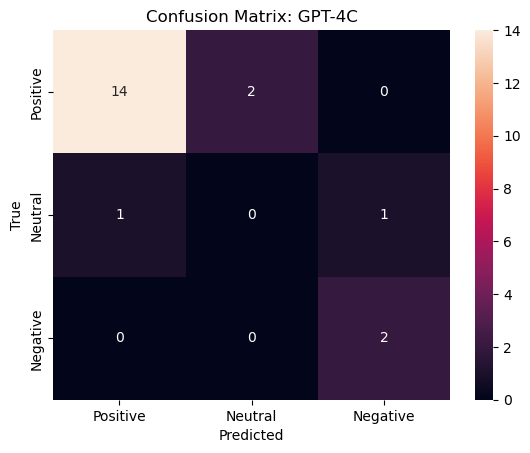

In [18]:
def evaluate_sentiment(true, pred, model_name):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average='macro')
    cm = confusion_matrix(true, pred, labels=["Positive", "Neutral", "Negative"])

    print(f"\n📊 {model_name} - Sentiment Classification")
    print(f"Accuracy: {acc:.2f}")
    print(f"F1 Score: {f1:.2f}")
    
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=["Positive", "Neutral", "Negative"], yticklabels=["Positive", "Neutral", "Negative"])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


evaluate_sentiment(test["true_sent"], test["GPT-4_sent_v1"], "GPT-4A")
evaluate_sentiment(test["true_sent"], test["GPT-4_sent_v2"], "GPT-4B")
evaluate_sentiment(test["true_sent"], test["GPT-4_sent_v3"], "GPT-4C")


📊 google/flan-t5-large - Sentiment Classification
Accuracy: 0.90
F1 Score: 0.59


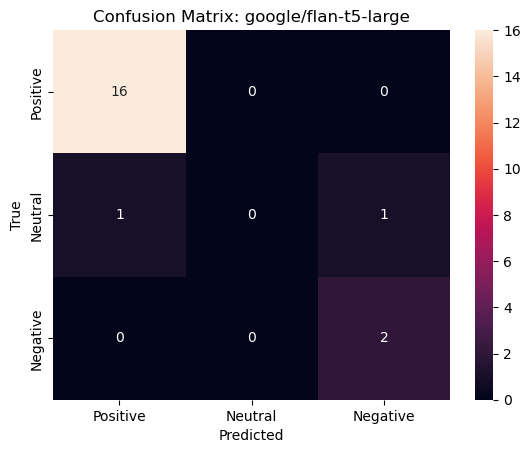


📊 google/flan-t5-large - Sentiment Classification
Accuracy: 0.90
F1 Score: 0.59


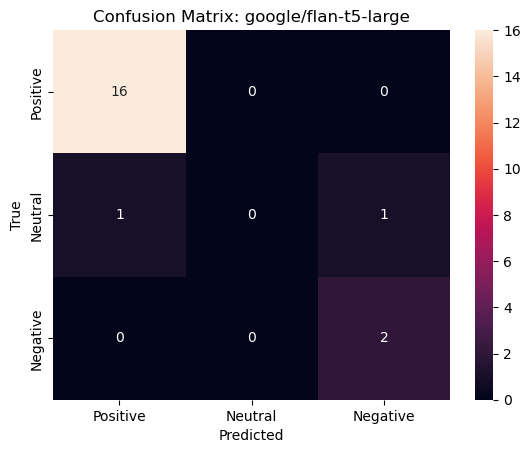


📊 google/flan-t5-large - Sentiment Classification
Accuracy: 0.90
F1 Score: 0.59


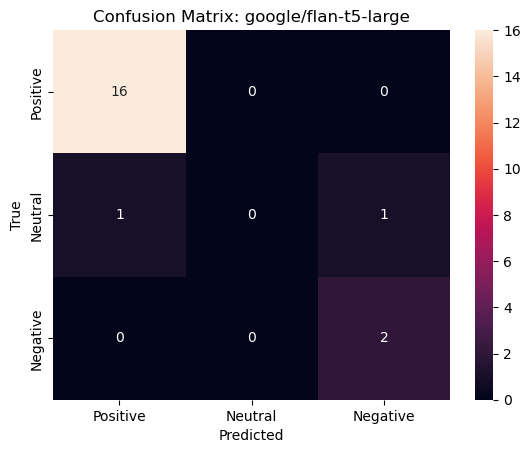

In [16]:
evaluate_sentiment(test["true_sent"], test["Sentiment_A"], "google/flan-t5-large")
evaluate_sentiment(test["true_sent"], test["Sentiment_B"], "google/flan-t5-large")
evaluate_sentiment(test["true_sent"], test["Sentiment_C"], "google/flan-t5-large")

### LLama-3 8B output

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "path/to/llama-3-8b"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [ ]:
def create_prompt_sentiment(review_text: str, version: str="A") -> str:
    """Create a sentiment classification prompt for a given review text."""
    if version == "A":
        # Version A: straightforward instruction
        return f"Classify the sentiment of this review as Positive, Neutral, or Negative:\n\n{review_text}"
    elif version == "B":
        # Version B: role prompt with explicit output instruction
        return (
            "You are a sentiment classifier for touristic place reviews. "
            "Output one of the following: Positive, Neutral, or Negative.\n"
            f"Content: {review_text}"
        )
    elif version == "C":
        # Version C: detailed instructions about sentiment analysis
        return (
            "Sentiment Analysis Task:\n"
            "Please assess the sentiment of this customer review of a touristic destination. "
            "Read everything and take all cues into account (including negations or sarcasm). "
            "Choose from: Positive / Neutral / Negative.\n\n"
            f"Content:\n\"{review_text}\""
        )
    else:
        raise ValueError("Invalid version for sentiment prompt")

def create_prompt_extraction(review_text: str, version: str="A") -> str:
    """Create a complaint/praise extraction prompt for a given review text."""
    if version == "A":
        # Version A: direct instruction, no explanation
        return (
            "Extract the most important sentence or phrase that expresses a key complaint or praise in the following customer review. "
            "Return no more than 4 words. Do not explain.\n\n"
            f"Review:\n\"{review_text}\"\n\n"
            "Respond only with the extracted sentence or phrase."
        )
    elif version == "B":
        # Version B: role-based prompt with guidance on length
        return (
            "You are a customer sentiment analyst. Read the review and extract the core complaint or praise, no more than 4 words long.\n\n"
            "Extract only the most significant phrase showing what the customer felt most strongly about. "
            "Return a phrase 4 words or fewer. Do not provide any explanation.\n"
            f"Review:\n\"{review_text}\""
        )
    elif version == "C":
        # Version C: structured task with examples in instructions
        return (
            "Task: Identify the key complaint or praise in this review, in no more than 4 words.\n\n"
            f"Review:\n\"{review_text}\"\n\n"
            "Instructions:\n"
            "- If the review is mostly positive, output the main thing being praised.\n"
            "- If mostly negative, output the main complaint.\n"
            "- Limit your answer to 4 words or fewer.\n\n"
            "Output:"
        )
    else:
        raise ValueError("Invalid version for extraction prompt")

def create_prompt_summary(review_text: str, version: str="A") -> str:
    """Create a summarization prompt for a given review text."""
    if version == "A":
        # Version A: simple instruction to summarize
        return f"Summarize this customer review in 1-2 sentences:\n\n{review_text}"
    elif version == "B":
        # Version B: role prompt with explicit requirements
        return (
            "You are a summarization assistant. Read the following review and return a concise summary.\n"
            "The summary should be 1–2 sentences, capturing the main idea and sentiment. "
            "Write it in third person, staying factual and only using information from the review.\n\n"
            f"Review:\n{review_text}"
        )
    elif version == "C":
        # Version C: few-shot examples provided before the actual task
        return (
            'Here are example reviews and summaries:\n\n'
            'Review: "The ice cream was amazing and the staff were so friendly. A must-visit!"\n'
            'Summary: The reviewer loved the gelato and the friendly staff, calling it a must-visit.\n\n'
            'Review: "We waited forever and the ice cream was average. Not worth it."\n'
            'Summary: The reviewer felt the gelato was average and not worth the long wait.\n\n'
            f'Now, summarize the following review in 1-2 sentences.\n\nReview:\n"{review_text}"\n\nSummary:'
        )
    else:
        raise ValueError("Invalid version for summary prompt")

In [ ]:
sentiment_preds = {}
for version in ["A", "B", "C"]:
    predictions = []
    for review in df["Content"]:
        prompt = create_prompt_sentiment(review, version=version)
        inputs = tokenizer(prompt, return_tensors="pt")
        outputs = model.generate(**inputs, max_new_tokens=3, eos_token_id=tokenizer.eos_token_id)
        result = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
        sentiment = result.split()[0] if result else ""
        predictions.append(sentiment)
    sentiment_preds[version] = predictions
    df[f"LLaMA_sent_{version}"] = predictions  

In [ ]:
extraction_preds = {}
for version in ["A", "B", "C"]:
    predictions = []
    for review in df["Content"]:
        prompt = create_prompt_extraction(review, version=version)
        inputs = tokenizer(prompt, return_tensors="pt")
        outputs = model.generate(**inputs, max_new_tokens=6, eos_token_id=tokenizer.eos_token_id)
        result = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
        phrase = result.strip('." ')
        phrase = ' '.join(phrase.split()[:4])
        predictions.append(phrase)
    extraction_preds[version] = predictions
    df[f"LLaMA_ext_{version}"] = predictions

In [ ]:
summary_preds = {}
for version in ["A", "B", "C"]:
    predictions = []
    for review in df["Content"]:
        prompt = create_prompt_summary(review, version=version)
        inputs = tokenizer(prompt, return_tensors="pt")
        outputs = model.generate(**inputs, max_new_tokens=50, eos_token_id=tokenizer.eos_token_id)
        result = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
        summary = result
        predictions.append(summary)
    summary_preds[version] = predictions
    df[f"LLaMA_sum_{version}"] = predictions

### Evaluation of the outputs

In [ ]:
def token_level_scores(true_phrases, pred_phrases):
    precision_list, recall_list, f1_list = [], [], []
    for true, pred in zip(true_phrases, pred_phrases):
        true_tokens = re.findall(r"\w+", str(true).lower())
        pred_tokens = re.findall(r"\w+", str(pred).lower())
        if len(pred_tokens) == 0:
            if len(true_tokens) == 0:
                prec = rec = 1.0 
            else:
                prec = rec = 0.0
        else:
            common = sum((token in true_tokens) for token in pred_tokens)
            prec = common / len(pred_tokens) if pred_tokens else 0
            rec = common / len(true_tokens) if true_tokens else 0
        f1 = 2*prec*rec/(prec+rec) if (prec+rec) > 0 else 0.0
        precision_list.append(prec)
        recall_list.append(rec)
        f1_list.append(f1)
    return np.mean(precision_list), np.mean(recall_list), np.mean(f1_list)


true_sentiments = df["true_sent"]
true_phrases = df["true_extraction"]



for version in ["A", "B", "C"]:
    preds = sentiment_preds[version]
    acc = accuracy_score(true_sentiments, preds)
    f1 = f1_score(true_sentiments, preds, average='macro', labels=["Positive","Neutral","Negative"])
    print(f"LLaMA_{version} – Sentiment: Accuracy = {acc:.2f}, Macro F1 = {f1:.2f}")
    cm = confusion_matrix(true_sentiments, preds, labels=["Positive","Neutral","Negative"])
    print("Confusion Matrix:\n", cm)


for version in ["A", "B", "C"]:
    preds = extraction_preds[version]
    exact_matches = sum(str(p).strip().lower() == str(t).strip().lower() for p,t in zip(preds, true_phrases))
    em_rate = exact_matches / len(df)
    prec, rec, f1 = token_level_scores(true_phrases, preds)
    print(f"LLaMA_{version} – Extraction: Exact Match = {em_rate:.2%}, Token P = {prec:.2f}, R = {rec:.2f}, F1 = {f1:.2f}")


from itertools import zip_longest

# Choose GPT-4's version 3 summaries as reference (assuming high-quality reference)
references = df["GPT-4_summary_v3"].fillna("").tolist()


def compute_rouge(preds, refs):
    def LCS(a, b):
        dp = [[0]*(len(b)+1) for _ in range(len(a)+1)]
        for i in range(1, len(a)+1):
            for j in range(1, len(b)+1):
                if a[i-1] == b[j-1]:
                    dp[i][j] = dp[i-1][j-1] + 1
                else:
                    dp[i][j] = max(dp[i-1][j], dp[i][j-1])
        return dp[-1][-1]
    rouge1_f1_list = []
    rougeL_f1_list = []
    for pred, ref in zip_longest(preds, refs, fillvalue=""):
        pred_words = re.findall(r"\w+", str(pred).lower())
        ref_words = re.findall(r"\w+", str(ref).lower())
        overlap1 = 0
        ref_counts = {}
        for w in ref_words:
            ref_counts[w] = ref_counts.get(w, 0) + 1
        for w in pred_words:
            if ref_counts.get(w, 0) > 0:
                overlap1 += 1
                ref_counts[w] -= 1
        if ref_words:
            r1_recall = overlap1 / len(ref_words)
        else:
            r1_recall = 0
        if pred_words:
            r1_prec = overlap1 / len(pred_words)
        else:
            r1_prec = 0
        r1_f1 = 2 * r1_prec * r1_recall / (r1_prec + r1_recall) if (r1_prec + r1_recall) > 0 else 0.0
        lcs_len = LCS(pred_words, ref_words)
        rL_recall = lcs_len / len(ref_words) if ref_words else 0
        rL_prec   = lcs_len / len(pred_words) if pred_words else 0
        rL_f1 = 2 * rL_prec * rL_recall / (rL_prec + rL_recall) if (rL_prec + rL_recall) > 0 else 0.0
        rouge1_f1_list.append(r1_f1)
        rougeL_f1_list.append(rL_f1)
    return np.mean(rouge1_f1_list), np.mean(rougeL_f1_list)

for version in ["A", "B", "C"]:
    preds = summary_preds[version]
    rouge1, rougeL = compute_rouge(preds, references)
    print(f"LLaMA_{version} – Summarization: ROUGE-1 F1 = {rouge1:.3f}, ROUGE-L F1 = {rougeL:.3f}")